In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import json
import time
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, precision_recall_curve

In [2]:
login_times = pd.read_json('logins.json')

# 1. EDA

In [3]:
login_times.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
login_times.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [5]:
login_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
login_times.set_index('login_time', inplace=True)
login_times['count'] = 1
login_times.sort_index(inplace=True)
login_times_agg = login_times.resample("15min").sum()

In [7]:
login_times_agg.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [8]:
login_times_agg['count'].sum()

93142

In [9]:
login_times_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


In [10]:
today = datetime.datetime(2017, 10, 20)
today.weekday()  # what I look for

4

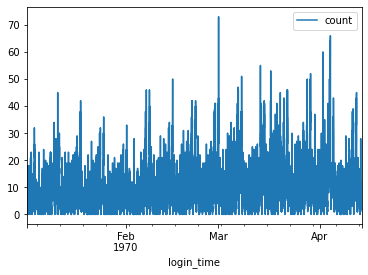

In [11]:
login_times_agg.plot()
plt.show()

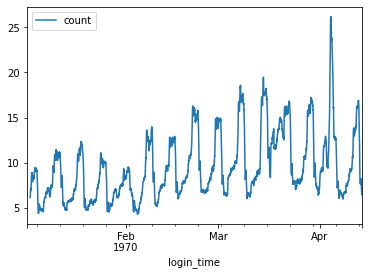

In [12]:
login_times_agg.rolling(window=96).mean().plot()
plt.show()


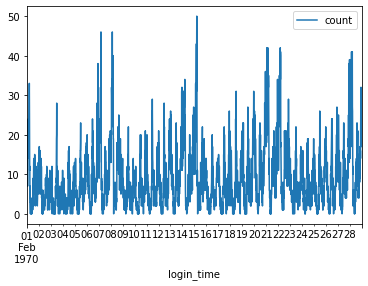

In [13]:
login_times_agg.loc['1970-02'].plot()
plt.show()

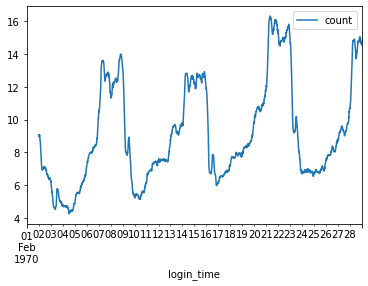

In [14]:
login_times_agg.loc['1970-02'].rolling(window=96).mean().plot()
plt.show()

In [15]:
datetime.datetime(1970, 2, 1).weekday()

6

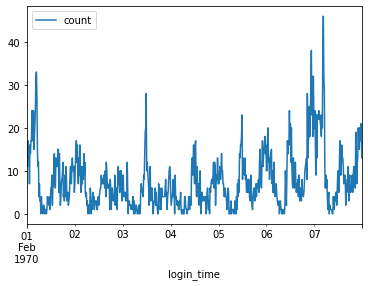

In [16]:
login_times_agg.loc['1970-02-01':'1970-02-07'].plot()
plt.show()

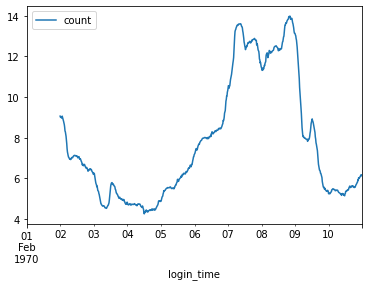

In [17]:
login_times_agg.loc['1970-02-01':'1970-02-10'].rolling(window=96).mean().plot()
plt.show()

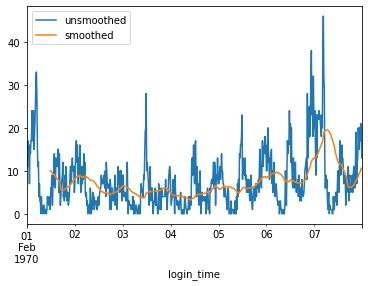

In [18]:
unsmoothed = login_times_agg['count']['1970-02-01':'1970-02-07']
smoothed = unsmoothed.rolling(window=48).mean()
one_week = pd.DataFrame({'unsmoothed':unsmoothed, 'smoothed':smoothed})
one_week.plot()
plt.show()

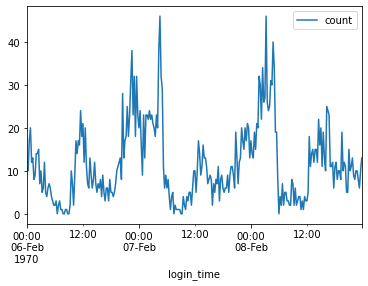

In [19]:
login_times_agg.loc['1970-02-06':'1970-02-08'].plot()
plt.show()

# 2. Experiment and Metrics Design

Checkout the associated PDF in this repository for this section

# 3. Predictive Modelling

In [21]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
df = pd.DataFrame(data)

In [22]:
display(df.shape)
display(df.info())
display(df.columns)

(50000, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


None

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [23]:
df.describe()


,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [24]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [25]:
df.tail(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
49990,Astapor,1,2014-01-13,4.7,1.08,2014-05-18,iPhone,33.3,True,33.3,3.38,5.0
49991,Winterfell,0,2014-01-08,5.0,1.25,2014-06-29,iPhone,100.0,False,0.0,1.06,5.0
49992,King's Landing,1,2014-01-18,1.0,1.00,2014-01-19,iPhone,0.0,False,0.0,7.58,5.0
49993,Astapor,3,2014-01-03,4.8,1.11,2014-07-01,iPhone,11.1,True,55.6,2.53,4.7
49994,Astapor,1,2014-01-03,4.6,1.44,2014-05-31,iPhone,37.5,False,25.0,2.25,4.5
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5
49999,Astapor,0,2014-01-18,NaN,1.00,2014-04-20,Android,0.0,False,0.0,3.49,5.0


In [26]:
df.last_trip_date[0]

'2014-06-17'

In [27]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [29]:
df['last_trip_date'].describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [30]:
fraction_retained = (df.last_trip_date >= '2014-06-01').sum() / (df.last_trip_date >= '2014-06-01').count()
fraction_retained

0.37608

In [31]:
df['was_retained'] = (df.last_trip_date >= '2014-06-01')*1
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,was_retained
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.376080
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652,0.484405
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  was_retained            50000 non-null  int64 

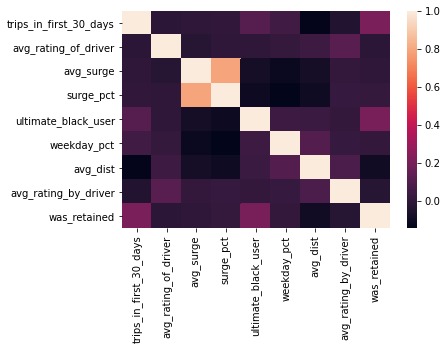

In [33]:
fig = plt.figure()
ax = plt.subplot(111)
corr = df.corr()
ax = sns.heatmap(corr)
plt.show()

In [34]:

corr['was_retained'].sort_values(ascending=False)

was_retained              1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.011653
avg_rating_by_driver     -0.026791
avg_dist                 -0.092780
Name: was_retained, dtype: float64

In [35]:
df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [36]:
df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [38]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
df = pd.DataFrame(data)

df['was_retained'] = (df.last_trip_date >= '2014-06-01')*1
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)
df['signup_date'] = df['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100
df['last_trip_date'] = (df['last_trip_date'] - min(df['last_trip_date'])).dt.days + 1

In [39]:
#### Step 1: Preprocess Data
np.random.seed(0)

df.phone.fillna('Other', inplace=True)
categorical_features = ['city', 'phone']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder())
]
)

numeric_features = [column for column in df.columns.tolist() if column not in categorical_features and
                    column not in ['last_trip_date', 'was_retained']]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
]
)

In [40]:
#### Step 2) Split Data into Training and Test Sets
X = df.drop(['was_retained', 'last_trip_date'], axis=1)
y = df['was_retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [41]:
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'AUC', 'Time to Train'], 
                       columns=['Dummy Model', 'Logistic Regression', 'K Nearest Neighbors', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Naive Bayes'])

In [42]:
metrics

,Dummy Model,Logistic Regression,K Nearest Neighbors,Support Vector Machine,Decision Tree,Random Forest,Naive Bayes
accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AUC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time to Train,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:

# Steps 5 - 8:
def train_and_score_model(model_name, estimator, param_grid=None, cv=5, iid=False):
    
    #### Step 5: Instantiate the CV Object
    
    if model_name in ['Dummy Model', 'Naive Bayes']:
        cv = estimator
    elif model_name == 'Logistic Regression':
        cv = GridSearchCV(estimator, param_grid, cv=cv, iid=False)
    else: 
        cv = RandomizedSearchCV(estimator, param_grid, cv=cv, iid=False, random_state=None)

    #### Step 6: Fit on Training
    t0 = time.time()
    cv.fit(X_train, y_train)
    ttt = time.time() - t0 # ttt stands for "time to train"
    print("It takes %.3f seconds for %s fitting" % (ttt, model_name))
    metrics.loc['Time to Train', model_name] = ttt

    #### Step 7: Predict on Test

    y_pred = cv.predict(X_test)

    #### Step 8: Scoring
    ##### Accuracy

    print("Accuracy with " + model_name + "on the testing set is: %.3f" % cv.score(X_test, y_test))

    metrics.loc['accuracy', model_name] = accuracy_score(y_pred=y_pred, y_true=y_test)
    metrics.loc['precision', model_name] = precision_score(y_pred=y_pred, y_true=y_test)
    metrics.loc['recall', model_name] = recall_score(y_pred=y_pred, y_true=y_test)
    
    if model_name != 'Support Vector Machine':
        y_pred_prob = cv.predict_proba(X_test)[:,1]
        metrics.loc['AUC', model_name] = roc_auc_score(y_test, y_pred_prob)

    print(Conf_Matrix(confusion_matrix(y_test, y_pred)))
    print(classification_report(y_test, y_pred))

    if model_name != 'Support Vector Machine':
        # ROC Curve
        fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
        plt.plot([0,1], [0,1], 'k--')
        plt.plot(fpr, tpr, label=model_name)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('%s ROC Curve' % model_name)
        plt.show()

    return cv

In [44]:
def Conf_Matrix(CM, labels=['Not Retained', 'Retained']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name = 'TRUE'
    df.columns.name = 'PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

In [45]:

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import randint


# Step 3: Instantiate the model/estimator
classifier_dm = DummyClassifier(strategy="most_frequent", random_state=0)
classifier_lr = LogisticRegression(solver='liblinear', random_state=0)
classifier_knn = KNeighborsClassifier()
classifier_svm = SVC(random_state=0)
classifier_dt = DecisionTreeClassifier(random_state=0)
classifier_rf = RandomForestClassifier(random_state=0)
classifier_nb = GaussianNB()

classifiers = [classifier_dm, classifier_lr, classifier_knn, classifier_svm, classifier_dt, classifier_rf, classifier_nb]

# Step 4: Specify the Hyperparameter Space
param_grid_dm = None
param_grid_lr = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': np.logspace(-5, 8, 15),
    'classifier__penalty': ['l1', 'l2']
}
param_grid_knn = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__n_neighbors': np.arange(1,20)
}
param_grid_svm = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01]
}
param_grid_dt = {
                'preprocessor__num__imputer__strategy': ['mean', 'median'],
                'classifier__max_depth': [3, 10, 20, None],
                'classifier__max_features': randint(1, 9),
                'classifier__min_samples_leaf': randint(1, 9),
                'classifier__min_samples_split': randint(2, 9),
                'classifier__criterion': ["gini", "entropy"]
}
param_grid_rf = {
                 'preprocessor__num__imputer__strategy': ['mean', 'median'], 
                 'classifier__n_estimators': [50, 100],
                 'classifier__criterion': ["gini", "entropy"],
                 'classifier__max_depth': [3, 10, 20, None],
                 'classifier__min_samples_leaf': randint(1, 9),
                 'classifier__min_samples_split': randint(2, 9),
                 'classifier__max_features': randint(1, 9)
}
param_grid_nb = None

param_grids = [param_grid_dm, param_grid_lr, param_grid_knn, param_grid_svm, param_grid_dt, param_grid_rf, param_grid_nb]

model_names = ['Dummy Model', 'Logistic Regression', 'K Nearest Neighbors', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Naive Bayes']
cv_names = ['dm_cv', 'lr_cv', 'knn_cv', 'svm_cv', 'dt_cv', 'rf_cv', 'nb_cv']
cvs = [None, 5, 5, 5, 5, 5, 5]

It takes 0.217 seconds for Dummy Model fitting
Accuracy with Dummy Modelon the testing set is: 0.624
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          9359         0   9359
Retained              5641         0   5641
Total                15000         0  15000


/home/epoch/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/epoch/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.62      1.00      0.77      9359
           1       0.00      0.00      0.00      5641

    accuracy                           0.62     15000
   macro avg       0.31      0.50      0.38     15000
weighted avg       0.39      0.62      0.48     15000



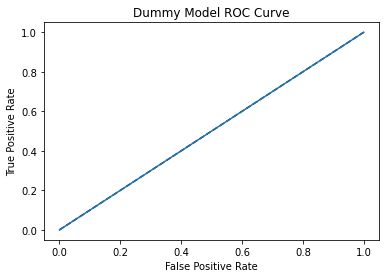

/home/epoch/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


It takes 68.461 seconds for Logistic Regression fitting
Accuracy with Logistic Regressionon the testing set is: 0.716
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          7984      1375   9359
Retained              2880      2761   5641
Total                10864      4136  15000
              precision    recall  f1-score   support

           0       0.73      0.85      0.79      9359
           1       0.67      0.49      0.56      5641

    accuracy                           0.72     15000
   macro avg       0.70      0.67      0.68     15000
weighted avg       0.71      0.72      0.71     15000



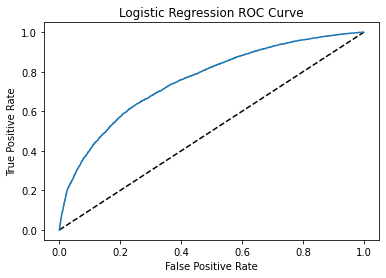

/home/epoch/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


It takes 133.825 seconds for K Nearest Neighbors fitting
Accuracy with K Nearest Neighborson the testing set is: 0.750
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          7739      1620   9359
Retained              2125      3516   5641
Total                 9864      5136  15000
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      9359
           1       0.68      0.62      0.65      5641

    accuracy                           0.75     15000
   macro avg       0.73      0.73      0.73     15000
weighted avg       0.75      0.75      0.75     15000



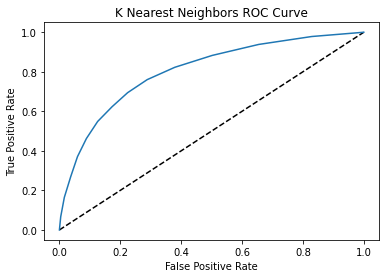

In [ ]:

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                 ('classifier', classifier_dm)])
dm_cv = train_and_score_model('Dummy Model', pipeline, param_grid_dm)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_lr)])
lr_cv = train_and_score_model('Logistic Regression', pipeline, param_grid_lr)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_knn)])
knn_cv = train_and_score_model('K Nearest Neighbors', pipeline, param_grid_knn)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_svm)])
svm_cv = train_and_score_model('Support Vector Machine', pipeline, param_grid_svm)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_dt)])
dt_cv = train_and_score_model('Decision Tree', pipeline, param_grid_dt)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_rf)])
rf_cv = train_and_score_model('Random Forest', pipeline, param_grid_rf)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_nb)])
nb_cv = train_and_score_model('Naive Bayes', pipeline, param_grid_nb)